In [2]:
# Import Libraries #
import findspark
findspark.init()
from pyspark.sql.functions import split, col, array_contains, translate, round, size, when, udf, lit, mean, count, format_number, collect_list
from pyspark.sql.types import TimestampType, MapType, IntegerType, StringType, ArrayType, FloatType, StructField, StructType
from pyspark.sql import SparkSession
from helper import *

spark = SparkSession.builder.appName('test').master("yarn") \
.config("spark.executor.instances", 12) \
.config("spark.executor.memory", "1G")  \
.getOrCreate()
## MUTE OUTPUT FROM SPARK
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.OFF)
logger.LogManager.getLogger("akka").setLevel(logger.Level.OFF)
spark.conf.set("spark.driver.log.level", "OFF")
#Event, White, Black, Result, WhiteElo, BlackElo, Opening, TimeControl, Termination, Moves,Eval, UTCTimestamp
schema = StructType([ \
    StructField("Event",StringType(),True), \
    StructField("White",StringType(),True), \
    StructField("Black",StringType(),True), \
    StructField("Result", StringType(), True), \
    StructField("WhiteElo", IntegerType(), True), \
    StructField("BlackElo", IntegerType(), True), \
    StructField("Opening",StringType(),True), \
    StructField("TimeControl",StringType(),True), \
    StructField("Termination",StringType(),True), \
    StructField("Moves", StringType(), True), \
    StructField("Eval", StringType(), True), \
    StructField("UTCTimestamp", TimestampType(), True) \
  ])
df = spark.read.csv("hdfs://namenode:9000/chess_2016_dataset/output/part*", schema=schema)

2023-04-14 13:31:44,742 INFO spark.SparkContext: Running Spark version 3.3.2
2023-04-14 13:31:45,141 INFO resource.ResourceUtils: ==============================================================
2023-04-14 13:31:45,145 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2023-04-14 13:31:45,146 INFO resource.ResourceUtils: ==============================================================
2023-04-14 13:31:45,148 INFO spark.SparkContext: Submitted application: test
2023-04-14 13:31:45,191 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2023-04-14 13:31:45,214 INFO resource.ResourceProfile: Limiting resource is cpus at 1 tasks per executor
2023-04-14 13:31:45,217 INFO resource.ResourceProfileManager: Added Resou

In [3]:
spark

##### Check Shape of Data

In [4]:
print("shape: ", (df.count(), len(df.columns)))

shape:  (1000, 12)


##### Convert columns to appropriate types

In [5]:
df = convert_types(df)
df.dtypes

[('Event', 'string'),
 ('White', 'string'),
 ('Black', 'string'),
 ('Result', 'string'),
 ('WhiteElo', 'int'),
 ('BlackElo', 'int'),
 ('Opening', 'string'),
 ('TimeControl', 'string'),
 ('Termination', 'string'),
 ('Moves', 'array<string>'),
 ('Eval', 'array<float>'),
 ('UTCTimestamp', 'timestamp')]

In [6]:
eval_difference = 3.0
eval_games = df.where(col("Eval")[0].isNotNull())
eval_games = eval_games.withColumn("WhiteBlunders", (find_white_blunders(col("Eval"), lit(eval_difference))))
eval_games = eval_games.withColumn("BlackBlunders", (find_black_blunders(col("Eval"), lit(eval_difference))))
eval_games.select("TimeControl", "White", "WhiteElo", "WhiteBlunders", "Black", "BlackElo", "BlackBlunders", "Result", "Termination") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(10).toPandas().head(10)

,TimeControl,White,WhiteElo,WhiteBlunders,Black,BlackElo,BlackBlunders,Result,Termination
0,600+0,dwp5321,1362,12,jujugaga,1295,9,1/2-1/2,Normal
1,480+0,joelbackman,1660,7,Rainbow52,1698,4,1/2-1/2,Time forfeit
2,300+0,hritic333,1812,5,jessehf,1799,2,0-1,Normal
3,90+0,Bogomdan,1380,5,prefe,1646,2,0-1,Time forfeit
4,600+0,dominguez1986,2005,4,yamyam15,1837,5,1-0,Normal
5,60+0,StEustache,1841,4,anirudhmehra,1545,3,1-0,Time forfeit
6,180+0,zelenimatej,1875,4,Andre_Sky,1672,3,1-0,Time forfeit
7,600+0,M_as19,1217,4,WattstheLoveguru,1288,2,0-1,Normal
8,900+5,venerabile48,1946,4,meev,1965,1,0-1,Normal
9,900+0,Sahinsah,1639,3,aerdna87,1634,9,1-0,Normal


##### Plot Most Blundered Game

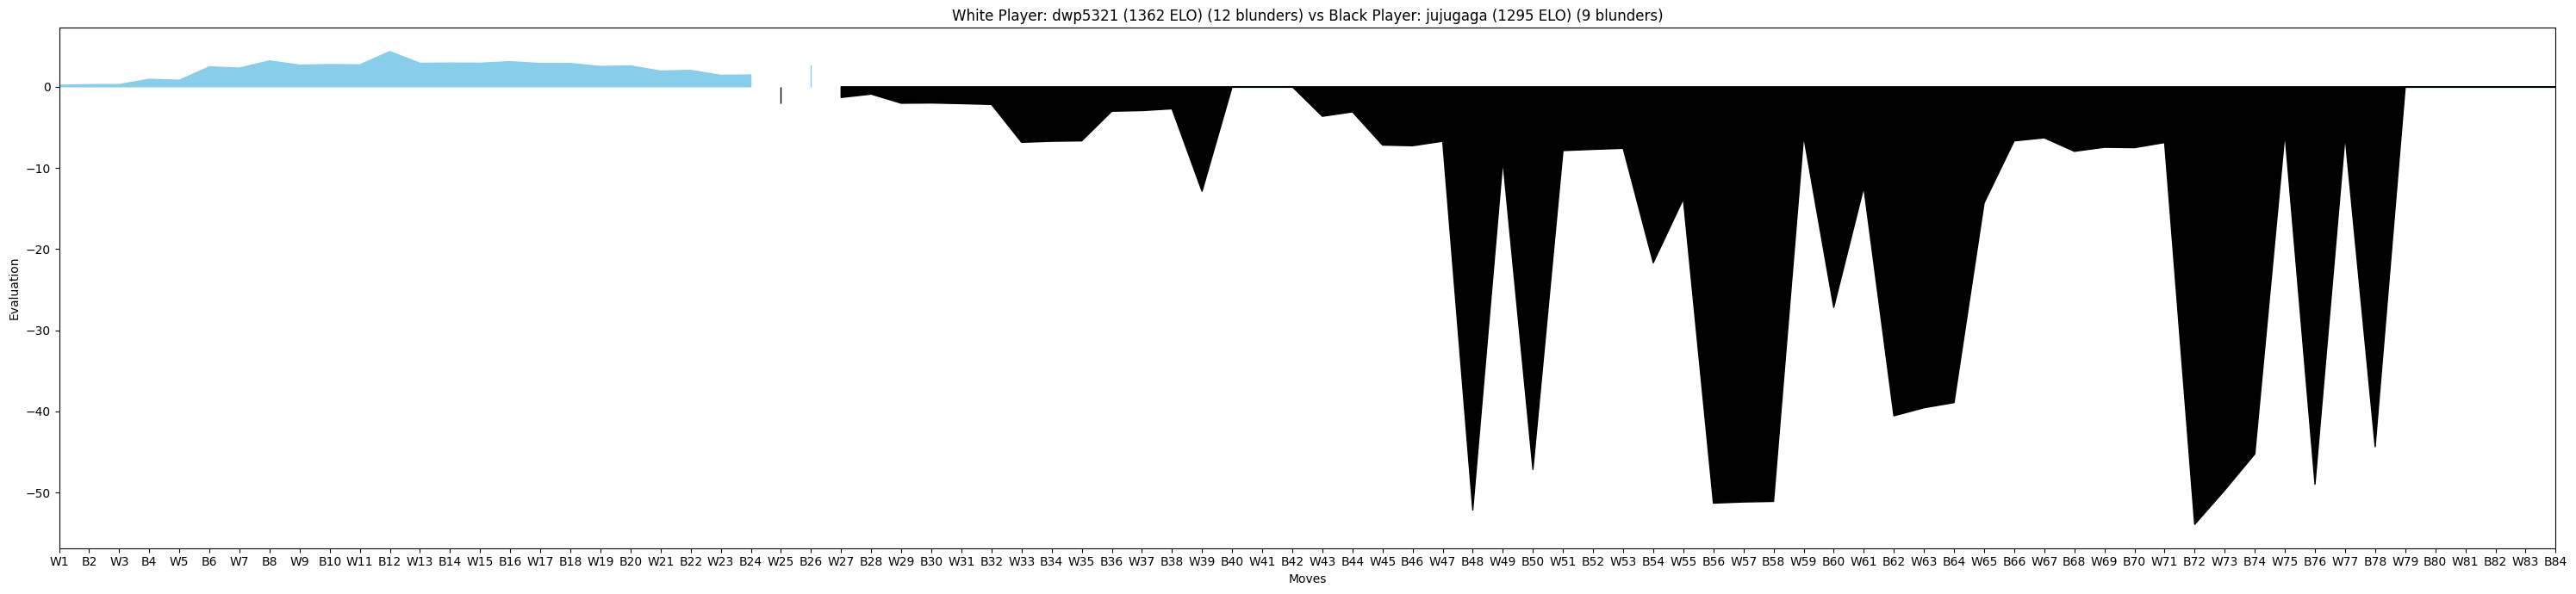

In [7]:
plot_eval_game(eval_games)

### Group By
- Time control ~ (60, 120, 180, 600) etc...
- Elo-Brackets ~ ([1200, 1400], [1500, 1700], [2000-2200]) etc...

#### Time Control Grouping

In [8]:
time_control_white_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders"), count("TimeControl")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

time_control_black_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("BlackBlunders"), count("TimeControl")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))


In [9]:
time_control_white_blunders_averages \
    .orderBy(col("avg(WhiteBlunders)").desc()) \
    .where(col("count(TimeControl)")>10000) \
    .limit(10) \
    .toPandas() \
    .head()

,TimeControl,avg(WhiteBlunders),count(TimeControl)


In [10]:
time_control_black_blunders_averages \
    .orderBy(col("avg(BlackBlunders)").desc()) \
    .where(col("count(TimeControl)")>100000) \
    .limit(10) \
    .toPandas() \
    .head()

,TimeControl,avg(BlackBlunders),count(TimeControl)


#### Elo Brackets Grouping

Start off by Creating a new spark daraframe column called "EloBracket" which we will later use to group and aggregrate by. When grouping the players by elo brackets we want to use a range that makes sense such that there are not 1 bracket that contains 80% of the playerbase and ones that only contain a small fraction. E.g We want evenly distributed amount of players in each bracket (as far as that is possible).

/tmp/ipykernel_278543/3116130490.py:5: UserWarning:                             

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(elo_list, kde=True, color ='red', bins=40)


<Axes: ylabel='Density'>

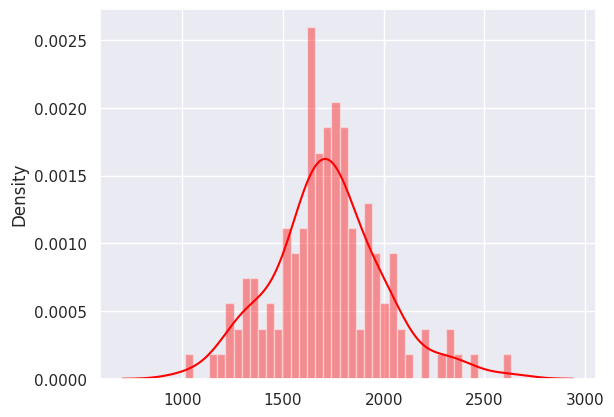

In [20]:
# Start by getting all the elo column values in the dataframe.
elo_list = eval_games.select(collect_list("WhiteElo")).first()[0]
sns.set_theme(style="ticks")
sns.set_style('darkgrid')
sns.distplot(elo_list, kde=True, color ='red', bins=40)

In [ ]:
time_control_white_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders"), count("TimeControl")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

time_control_black_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("BlackBlunders"), count("TimeControl")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))

In [ ]:
a = eval_games.select("Moves") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()) \
    .limit(1) \
    .take(1)[0][0]
print([x.replace("'","").replace('"', "").strip("'") for x in a])